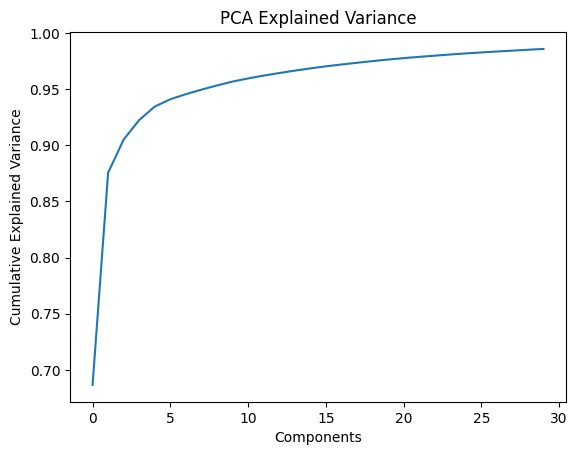

Best Accuracy after tuning: 0.6112195121951219


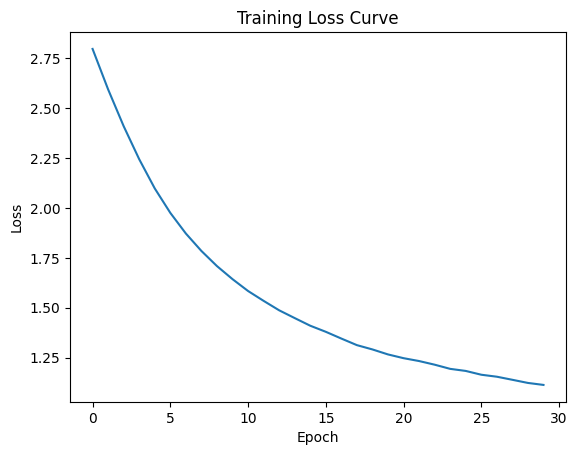

Ensemble Accuracy: 0.5190243902439025

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.57      0.36      0.45       286
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00        47
           4       1.00      0.01      0.02        97
           5       0.47      0.85      0.60       146
           6       0.00      0.00      0.00         5
           7       0.82      0.97      0.89        96
           8       0.00      0.00      0.00         4
           9       0.29      0.15      0.20       194
          10       0.45      0.93      0.61       491
          11       0.57      0.03      0.06       119
          12       0.00      0.00      0.00        41
          13       0.69      0.98      0.81       253
          14       0.00      0.00      0.00        77
          15       1.00      0.11      0.19        19

    accuracy      

C:\Users\balya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\balya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\balya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

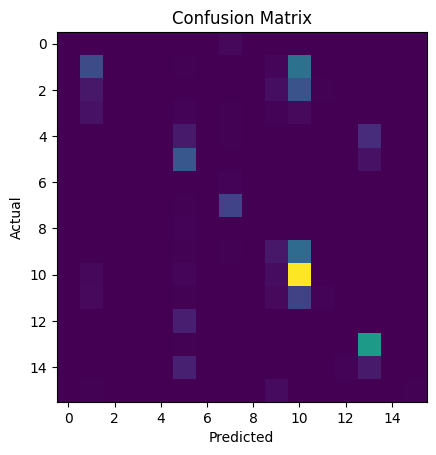

Class 1 Accuracy: 0.0000
Class 2 Accuracy: 0.3636
Class 3 Accuracy: 0.0000
Class 4 Accuracy: 0.0000
Class 5 Accuracy: 0.0103
Class 6 Accuracy: 0.8493
Class 7 Accuracy: 0.0000
Class 8 Accuracy: 0.9688
Class 9 Accuracy: 0.0000
Class 10 Accuracy: 0.1495
Class 11 Accuracy: 0.9328
Class 12 Accuracy: 0.0336
Class 13 Accuracy: 0.0000
Class 14 Accuracy: 0.9842
Class 15 Accuracy: 0.0000
Class 16 Accuracy: 0.1053
5-Fold CV Accuracy: 0.5153685438464926


In [1]:
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# =============================
# 1. Load Indian Pines Dataset
# =============================
data = sio.loadmat('Indian_pines_corrected.mat')
labels = sio.loadmat('Indian_pines_gt.mat')

X = data['indian_pines_corrected']
y = labels['indian_pines_gt']

# Reshape to (pixels, bands)
h, w, bands = X.shape
X = X.reshape(-1, bands)
y = y.reshape(-1)

# Remove unlabeled pixels (label 0)
mask = y > 0
X = X[mask]
y = y[mask] - 1   # zero-index classes

num_classes = len(np.unique(y))

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# =============================
# 2. PCA Reduction
# =============================
pca_components = 30
pca = PCA(n_components=pca_components)
X_pca = pca.fit_transform(X)

# Explained Variance Plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

# =============================
# 3. Define ANN Model
# =============================
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, num_classes):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden1),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# =============================
# 4. Training Function
# =============================
def train_model(model, X_train, y_train, epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return model, losses

# =============================
# 5. Train-Test Split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(y_test)

# =============================
# 6. Hyperparameter Tuning
# =============================
hidden_configs = [(128, 64), (256, 128)]
learning_rates = [0.001, 0.0005]

best_acc = 0
best_model = None

for h1, h2 in hidden_configs:
    for lr in learning_rates:
        model = MLP(pca_components, h1, h2, num_classes)
        model, losses = train_model(model, X_train_t, y_train_t, lr=lr)

        with torch.no_grad():
            preds = torch.argmax(model(X_test_t), dim=1)
            acc = accuracy_score(y_test, preds.numpy())

        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_losses = losses

print("Best Accuracy after tuning:", best_acc)

# =============================
# 7. Training Loss Curve
# =============================
plt.figure()
plt.plot(best_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# =============================
# 8. Ensemble of 3 Models
# =============================
models = []
for i in range(3):
    model = MLP(pca_components, 128, 64, num_classes)
    model, _ = train_model(model, X_train_t, y_train_t)
    models.append(model)

with torch.no_grad():
    preds = []
    for model in models:
        model.eval()
        output = torch.softmax(model(X_test_t), dim=1)
        preds.append(output)

    avg_preds = torch.mean(torch.stack(preds), dim=0)
    final_preds = torch.argmax(avg_preds, dim=1)

# =============================
# 9. Evaluation
# =============================
accuracy = accuracy_score(y_test, final_preds.numpy())
print("Ensemble Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, final_preds.numpy()))

cm = confusion_matrix(y_test, final_preds.numpy())

plt.figure()
plt.imshow(cm)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# =============================
# 10. Per-Class Accuracy
# =============================
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"Class {i+1} Accuracy: {acc:.4f}")

# =============================
# 11. K-Fold Cross Validation
# =============================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kf.split(X_pca):
    X_train_k, X_test_k = X_pca[train_idx], X_pca[test_idx]
    y_train_k, y_test_k = y[train_idx], y[test_idx]

    X_train_k = torch.FloatTensor(X_train_k)
    X_test_k = torch.FloatTensor(X_test_k)
    y_train_k = torch.LongTensor(y_train_k)

    model = MLP(pca_components, 128, 64, num_classes)
    model, _ = train_model(model, X_train_k, y_train_k)

    with torch.no_grad():
        preds = torch.argmax(model(X_test_k), dim=1)
        acc = accuracy_score(y_test_k, preds.numpy())
        cv_scores.append(acc)

print("5-Fold CV Accuracy:", np.mean(cv_scores))